# Import necessary packages

In [3]:
import sys
import pickle
import heapq
import numpy as np
np.random.seed(42)

In [4]:
import tensorflow as tf
tf.set_random_seed(42)

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# Loading the data

In [6]:
path = '../../datasets/nietzsche.txt'
text = open(path).read().lower()
print('corpus length: {}'.format(len(text)))

corpus length: 600894


In [7]:
text[:1000]

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, have been unskilled and unseemly methods for\nwinning a woman? certainly she has never allowed herself to be won; and\nat present every kind of dogma stands with sad and discouraged mien--if,\nindeed, it stands at all! for there are scoffers who maintain that it\nhas fallen, that all dogma lies on the ground--nay more, that it is at\nits last gasp. but to speak seriously, there are good grounds for hoping\nthat all dogmatizing in philosophy, whatever solemn, whatever conclusive\nand decided airs it has assumed, may have been only a noble puerilism\nand tyronism; and probably the time is at hand when it will be once\nand again understood what has actually sufficed for the basis of such\

# Preprocessing

In [8]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('unique chars: {}'.format(len(chars)))

unique chars: 57


In [9]:
print(char_indices)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '=': 22, '?': 23, '[': 24, ']': 25, '_': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, 'ä': 53, 'æ': 54, 'é': 55, 'ë': 56}


In [10]:
print(indices_char)

{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '=', 23: '?', 24: '[', 25: ']', 26: '_', 27: 'a', 28: 'b', 29: 'c', 30: 'd', 31: 'e', 32: 'f', 33: 'g', 34: 'h', 35: 'i', 36: 'j', 37: 'k', 38: 'l', 39: 'm', 40: 'n', 41: 'o', 42: 'p', 43: 'q', 44: 'r', 45: 's', 46: 't', 47: 'u', 48: 'v', 49: 'w', 50: 'x', 51: 'y', 52: 'z', 53: 'ä', 54: 'æ', 55: 'é', 56: 'ë'}


In [11]:
# Limit the sentences length to chunks of seq_length characters
seq_length = 40

# Spaces between sentences
step = 3

# List to store the sentences
sentences = []

# List to store the next character to be predicted for each sentence
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
print('num training examples: {}'.format(len(sentences)))

num training examples: 200285


In [12]:
text[:50]

'preface\n\n\nsupposing that truth is a woman--what th'

In [13]:
sentences[0]

'preface\n\n\nsupposing that truth is a woma'

In [14]:
sentences[1]

'face\n\n\nsupposing that truth is a woman--'

In [15]:
sentences[2]

'e\n\n\nsupposing that truth is a woman--wha'

In [16]:
sentences[5]

'sing that truth is a woman--what then? i'

In [17]:
next_chars[5]

's'

In [18]:
# Create one-hot-encoded vectors
X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [19]:
len(X[0])

40

In [20]:
# Show 
print('Example of a single training sequence:\n {}\n'.format(sentences[100]))
print('Character to be predicted for it:\n {}'.format(next_chars[100]))

Example of a single training sequence:
 ve been unskilled and unseemly methods f

Character to be predicted for it:
 o


In [21]:
print('Training examples:\t{}\nSequence length:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(X[0][0])

Training examples:	200285
Sequence length:	40
Unique chars:		57
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False]


In [22]:
print('Training examples:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(y[0])

Training examples:	200285
Unique chars:		40
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False]


# Building the model

In [23]:
vocab_size = len(chars)

In [24]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
_________________________________________________________________
activation_1 (Activation)    (None, 57)                0         
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [43]:
# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 190270 samples, validate on 10015 samples
Epoch 1/20
190270/190270 [==============================] - 158s 833us/step - loss: 1.3737 - acc: 0.5847 - val_loss: 1.4895 - val_acc: 0.5544
Epoch 2/20
190270/190270 [==============================] - 157s 827us/step - loss: 1.3625 - acc: 0.5875 - val_loss: 1.4869 - val_acc: 0.5606
Epoch 3/20
190270/190270 [==============================] - 159s 834us/step - loss: 1.3579 - acc: 0.5882 - val_loss: 1.4968 - val_acc: 0.5536
Epoch 4/20
190270/190270 [==============================] - 159s 835us/step - loss: 1.3526 - acc: 0.5899 - val_loss: 1.4918 - val_acc: 0.5577
Epoch 5/20
190270/190270 [==============================] - 160s 842us/step - loss: 1.3502 - acc: 0.5905 - val_loss: 1.4966 - val_acc: 0.5543
Epoch 6/20
190270/190270 [==============================] - 161s 847us/step - loss: 1.3458 - acc: 0.5903 - val_loss: 1.5012 - val_acc: 0.5573
Epoch 7/20
190270/190270 [==============================] - 161s 847us/step - loss: 1.3410 - acc:

In [44]:
# Save the model
model.save('../../data/keyboard/keras_model.h5')
pickle.dump(history, open('../../data/keyboard/history.p', 'wb'))

In [47]:
# Load the model
model = load_model('../../data/keyboard/keras_model.h5')
history = pickle.load(open('../../data/keyboard/history.p', 'rb'))

## Evaluation

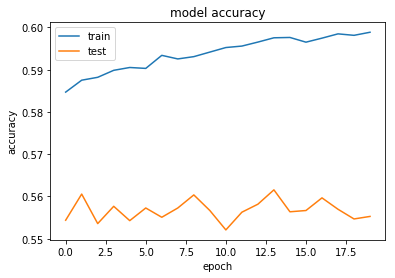

In [48]:
# Model accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

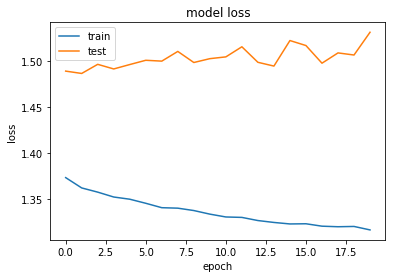

In [49]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Test

In [50]:
example_sentence = 'This is an example of input for our LSTM'

In [51]:
def prepare_input(text):
    text = text.lower()
    x = np.zeros((1, seq_length, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [52]:
prepare_input(example_sentence)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [53]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [54]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [55]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [56]:
# Quotes credited to F. Nietzsche
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [57]:
# Get top 5 most probable words to these sentences
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['all ', 'the ', 'so ', 'individual ', 'morality ']

that which does not kill us makes us str
['ongest ', 'ength, ', 'ive ', 'ange ', 'uck ']

i'm not upset that you lied to me, i'm u
['s ', 'pon ', 'nder ', 'fing, ', 'ats ']

and those who were seen dancing were tho
['usand ', 'rough ', 'se ', 'mest ', 'om--and ']

it is hard enough to remember my opinion
[' of ', ', ', 's ', '\nof ', 'ing ']

